## Imports

In [1]:
import os
import sys
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from datetime import datetime, timezone, timedelta
from numba import jit
import numpy as np
nltk.download("rslp");

[nltk_data] Downloading package rslp to /home/gus/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


### import modulos internos

In [2]:
sys.path.append("..")

In [3]:
from src.deployment.EDA_module import *
from src.data.data_cleaning_module import *

### Importando as stopwords do NLTK

In [4]:
stopwords = nltk.corpus.stopwords.words('portuguese')

### Configurando o tamanho padrão das figuras

In [5]:
plt.rcParams["figure.figsize"] = (16, 8)

### Carregamento do dataset

In [6]:
df = pd.read_csv("../data/raw/NoThemeTweets.csv")

### Checando a quantidade de tweets positivos e negativos percebe-se que há o dobro de valores negativos, ou seja, nossa base de dados é desbalanceada.

In [7]:
df.sentiment.value_counts()

Negativo    522707
Positivo    263107
Name: sentiment, dtype: int64

### Eliminando tweets que tenham menos de 5 palavras

In [8]:
df = df.assign(
    number_words = df.tweet_text.apply(lambda x: len(x.split(" "))),
)  # adiciona coluna com número de palavras

df = df.drop(
     df[df.number_words < 5].index
 )  # remove tweets com menos de 5 palavras

### Elimimando tweets repetidos da nossa base de dados

In [9]:
df.drop_duplicates(["tweet_text"], inplace = True)

### Pegando uma amostragem de 70k tweets para fazermos a análise exploratória

In [10]:
df = df.sample(70000, random_state = 42)

In [11]:
df.head(5)

,id,tweet_text,tweet_date,sentiment,query_used,number_words
336150,1038219150861185024,@juliabruder o sea começa de tarde miga :( dep...,Sat Sep 08 00:15:09 +0000 2018,Negativo,:(,19
218325,1030528213729067008,Quero dormir mas não posso :(,Fri Aug 17 18:54:07 +0000 2018,Negativo,:(,6
140649,1030838137424171015,Me doa seus tênis que você não usa mais :( — P...,Sat Aug 18 15:25:38 +0000 2018,Negativo,:(,22
179949,1031980737992564738,@KauaniModesto poxa nega pensei q viesse me ve...,Tue Aug 21 19:05:55 +0000 2018,Negativo,:(,9
15242,1031360746012258305,"rapaz, não acabou não e eu tô indo dormir de n...",Mon Aug 20 02:02:18 +0000 2018,Positivo,:),12


### Remoção de caracteres especiais, menções de usuários e links

In [12]:
df["tweet_text"] = df.tweet_text.apply(lambda x: formatar_texto(x))# exclui links e menções
df["tweet_text"] = df.tweet_text.apply(lambda x: remove_special_chars(x))# remove caracteres especiais

<h2 style="color:purple">Geração de novos dados.</h2>

### Formatação da hora

In [13]:
df["date"] = df.tweet_date.apply(lambda time: from_utc_to_local_time(time, -3))# custoso :(

In [14]:
df.drop(["tweet_date"], axis=1, inplace=True) # remoção de colunas desnecessárias

### Obtenção do período do dia

In [15]:
df["day_period"] = df.date.apply(lambda time: get_day_period(time))# aqui é bala!

### Adição de uma coluna com a contagem do numero de caracteres por palavras

In [16]:
df = df.assign(
    avg_word_length=df.tweet_text.str.split()
    .apply(lambda x: [len(i) for i in x])
    .map(lambda x: np.mean(x))
)  # adiciona coluna com média de caracteres por palavra no tweet

In [17]:
# copia do dataframe para que não haja problemas ao manipularmos os dados originais
formated_df = df.copy()

## Informações sombre o dataframe.

In [18]:
print(df.shape)
print(formated_df.describe())

formated_df.sample(5)

(70000, 8)
                 id  number_words  avg_word_length
count  7.000000e+04  70000.000000     70000.000000
mean   1.038515e+18     14.605743         4.163107
std    5.523479e+15      9.982020         0.864393
min    1.029537e+18      5.000000         1.000000
25%    1.032425e+18      7.000000         3.666667
50%    1.039286e+18     11.000000         4.083333
75%    1.042928e+18     18.000000         4.555556
max    1.050785e+18     70.000000        68.500000


,id,tweet_text,sentiment,query_used,number_words,date,day_period,avg_word_length
563869,1042512108783632384,hoje o dia foi tão tranquilo que até consegui ...,Positivo,:),16,2018-09-19 17:33:50+00:00,afternoon,4.600000
74597,1031740458035232768,ai eu amo tanto o taeyong,Negativo,:(,7,2018-08-21 00:11:08+00:00,overnight,3.333333
346614,1038143308831383554,hope night la 🌟🌙 eu ele é a coisinha mais fof...,Negativo,:(,13,2018-09-07 16:13:47+00:00,afternoon,3.333333
222823,1033385518485172224,sim mas fico com vontade,Negativo,:(,7,2018-08-25 13:08:01+00:00,afternoon,4.000000
136530,1030896922528235521,amanhã faço 18 anos e eu só queria tá fazendo 15,Negativo,:(,12,2018-08-18 16:19:14+00:00,afternoon,3.454545


## Histograma da quantidade de palavras nos tweets.
#### Nota-se claramente uma tendência dos tweets serem textos curtos, majoritariamente com menos de 20 palavras.

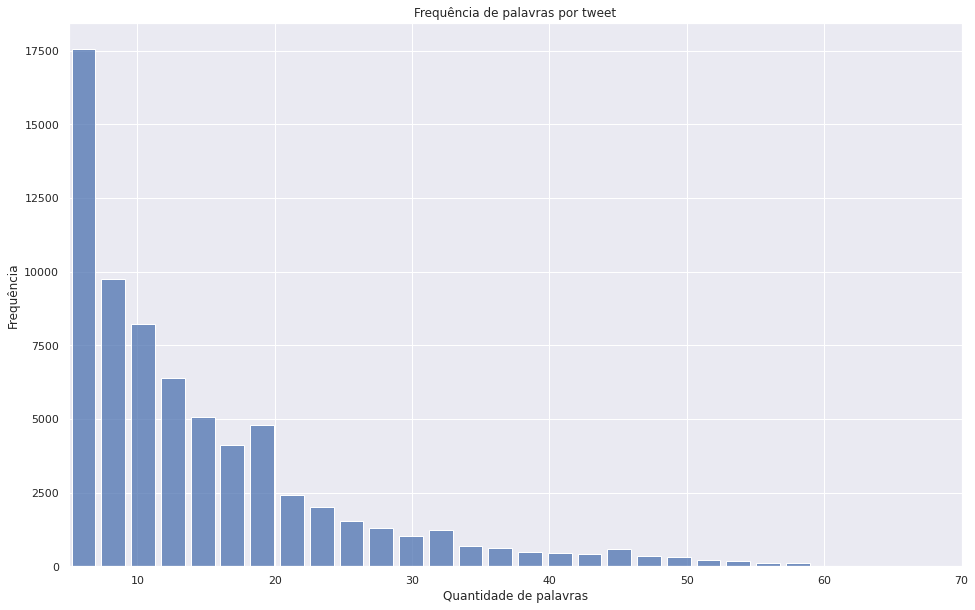

In [63]:
sns.set(rc={"figure.figsize": (16, 10)})
sns.histplot(data=formated_df, x="number_words", bins=30, shrink=0.8)

plt.xlabel("Quantidade de palavras")
plt.ylabel("Frequência")
plt.title("Frequência de palavras por tweet")
plt.xlim(formated_df.number_words.min(), formated_df.number_words.max())
plt.show()

<h2 style="color:red"> Essa etapa sera desconsiderada no momento pois ja sabemos que a quantidade de tweets positivos é  menor que o de negativos</h2>

## Histograma da quantidade de palavras nos tweets separados por sentimentos.
#### Nota-se claramente uma tendência dos tweets negativos serem mais curtos, contudo no dataset a uma maior quantidade de tweets negativos, praticamente o dobro isso deve ser considerado. Logo, a tendência seria que  os tweets negativos fossem cerca duas vezes em quantidade, contudo os tweets menores são ligeiramente maiores que o dobro, logo a uma leve tendência de tweets menores serem mais negativos.

In [20]:
# sns.set(rc={"figure.figsize": (12, 8)})
# sns.histplot(
#     data=formated_df,
#     x="number_words",
#     hue="sentiment",
#     bins=30,
#     palette={"Positivo": "green", "Negativo": "red"},
#     multiple="dodge",
#     shrink=0.8,h"].m
# )
# plt.xlabel("Quantidade de palavras")
# plt.ylabel("Frequência")
# plt.title("Frequência de palavras por tweet de acordo com o sentimento")
# plt.xlim(formated_df.number_words.min(), formated_df.number_words.max())
# plt.show()

## Tamanho médio das palavras em cada tweet

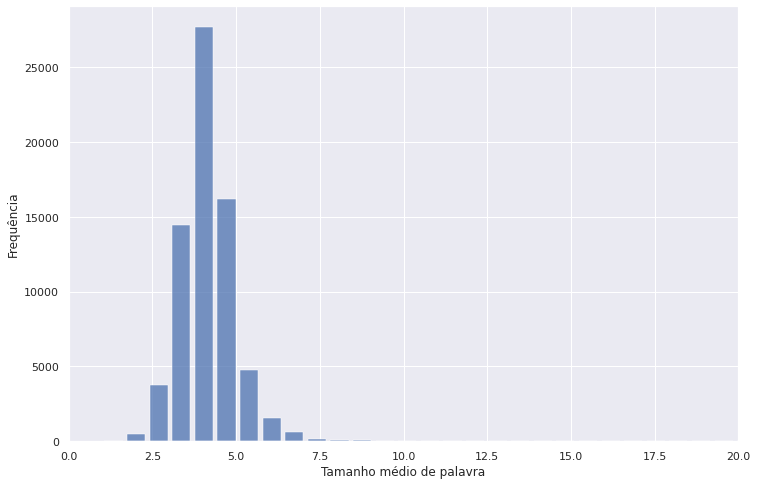

In [62]:
sns.set(rc={"figure.figsize": (12, 8)})

sns.histplot(data=formated_df, x="avg_word_length", bins=100, shrink=0.8)
plt.xlabel("Tamanho médio de palavra")
plt.ylabel("Frequência")
plt.xlim(0, 20)
plt.show()

## Separação dos dataframes em positivo e negativo e criação do corpus

In [22]:
df_positivo = formated_df.query("sentiment == 'Positivo'")
df_negativo = formated_df.query("sentiment == 'Negativo'")
df_all = formated_df

positive_text = " ".join(df_positivo.tweet_text)
negative_text = " ".join(df_negativo.tweet_text)
all_text = " ".join(df_all.tweet_text)

## Quantidade de tweets por período do dia.

#### Nota-se claramente que há uma maior quantidade de tweets de noite, provavelmente nos outros horários as pessoas estão ou trabalhando, estudando ou dormindo.

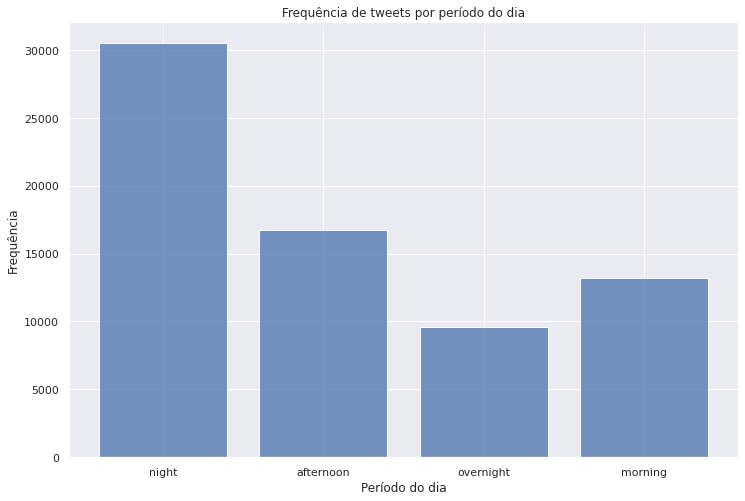

In [23]:
sns.histplot(data=formated_df, x="day_period", bins=5, shrink=0.8)
plt.xlabel("Período do dia")
plt.ylabel("Frequência")
plt.title("Frequência de tweets por período do dia")
plt.show()

### Plotagem da quantidade de tweets positivos vs negativos por período do dia
#### podemos observar que a quantidade de tweets negativos é sempre maior que a de positivos em qualquer período do dia, essa proporção de 2 para 1 foi observada nas etapas anteriores e é explicada pelo desbalanceamento nos dados, no entanto, a noite essa proporção aparenta ser um pouco maior.

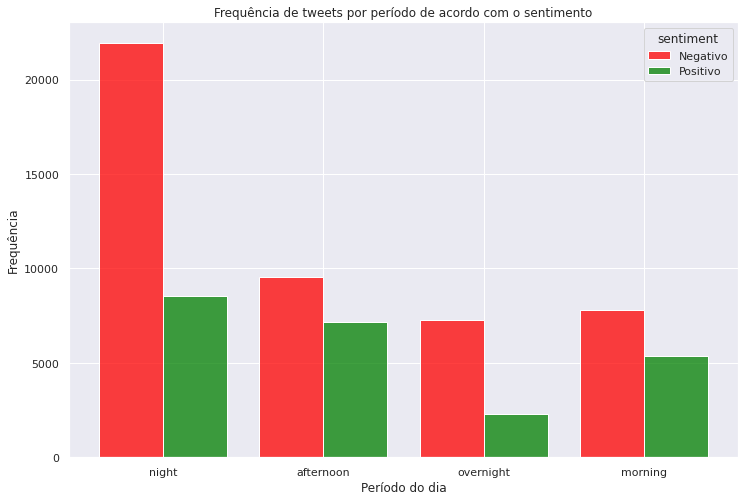

In [25]:
sns.histplot(
    data=formated_df,
    x="day_period",
    hue="sentiment",
    bins=5,
    palette={"Positivo": "green", "Negativo": "red"},
    multiple="dodge",
    shrink=0.8,
)
plt.xlabel("Período do dia")
plt.ylabel("Frequência")
plt.title("Frequência de tweets por período de acordo com o sentimento")
plt.show()

<h2 style="color:purple">Parte 2 - Criação do Corpus e verificação das Principais Stopwords</h2>

### Cria os top 50 stop words que mais aparecem no corpus

analyzed stopwords:
 ['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'já', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nós', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivesse

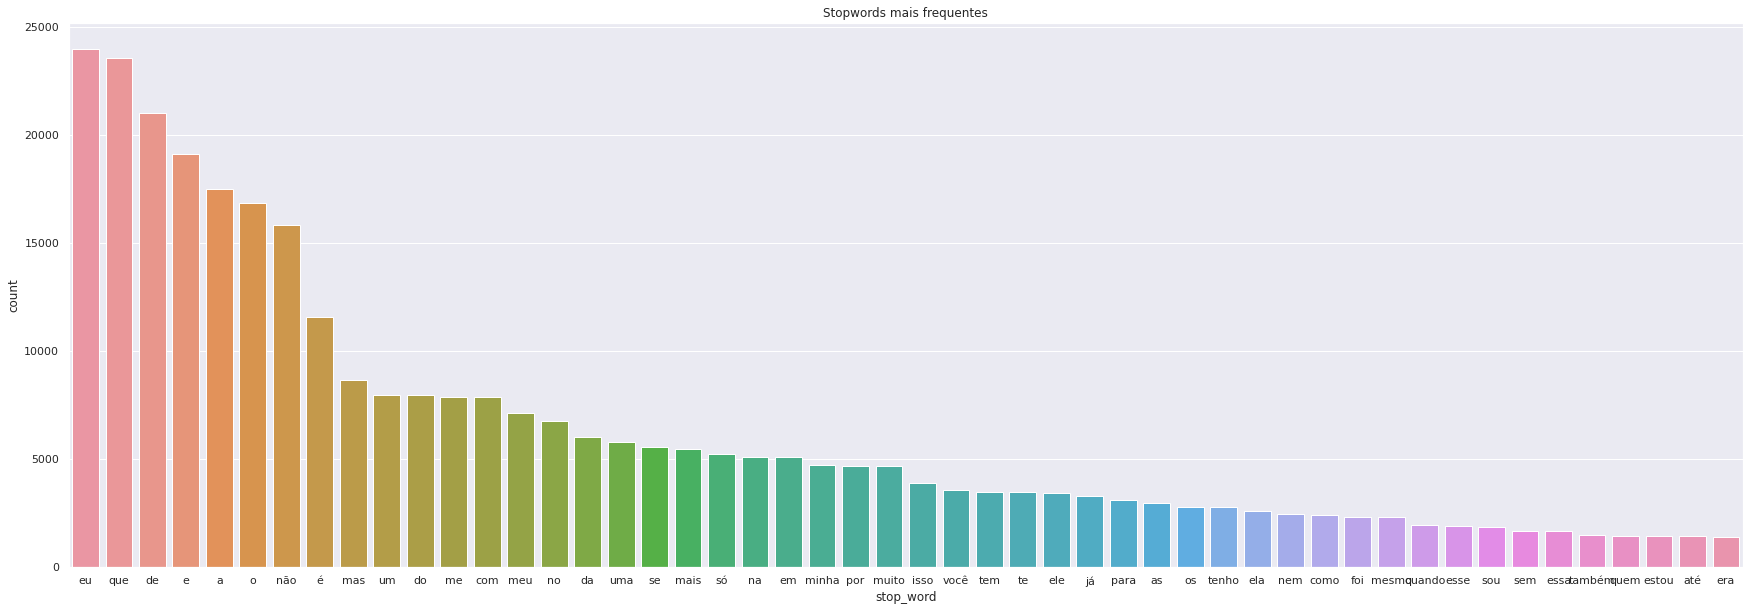

In [27]:
from collections import defaultdict

dic = defaultdict(int)

# stopwords = nltk.corpus.stopwords.words("portuguese")

print("analyzed stopwords:\n", stopwords)


for word in (all_text).split():
    if word in stopwords:
        dic[word] += 1


top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:50]  # top 50 stopwords


stopwords_df = pd.DataFrame(top, columns=["stop_word", "count"])


sns.set(rc={"figure.figsize": (30, 10)})
sns.barplot(x="stop_word", y="count", data=stopwords_df)
plt.title("Stopwords mais frequentes")
plt.show()

### O nltk considera como stop words algumas palavras que podem conter cunho sentimental, por conta disso essas palavras serão removidas desse vetor.

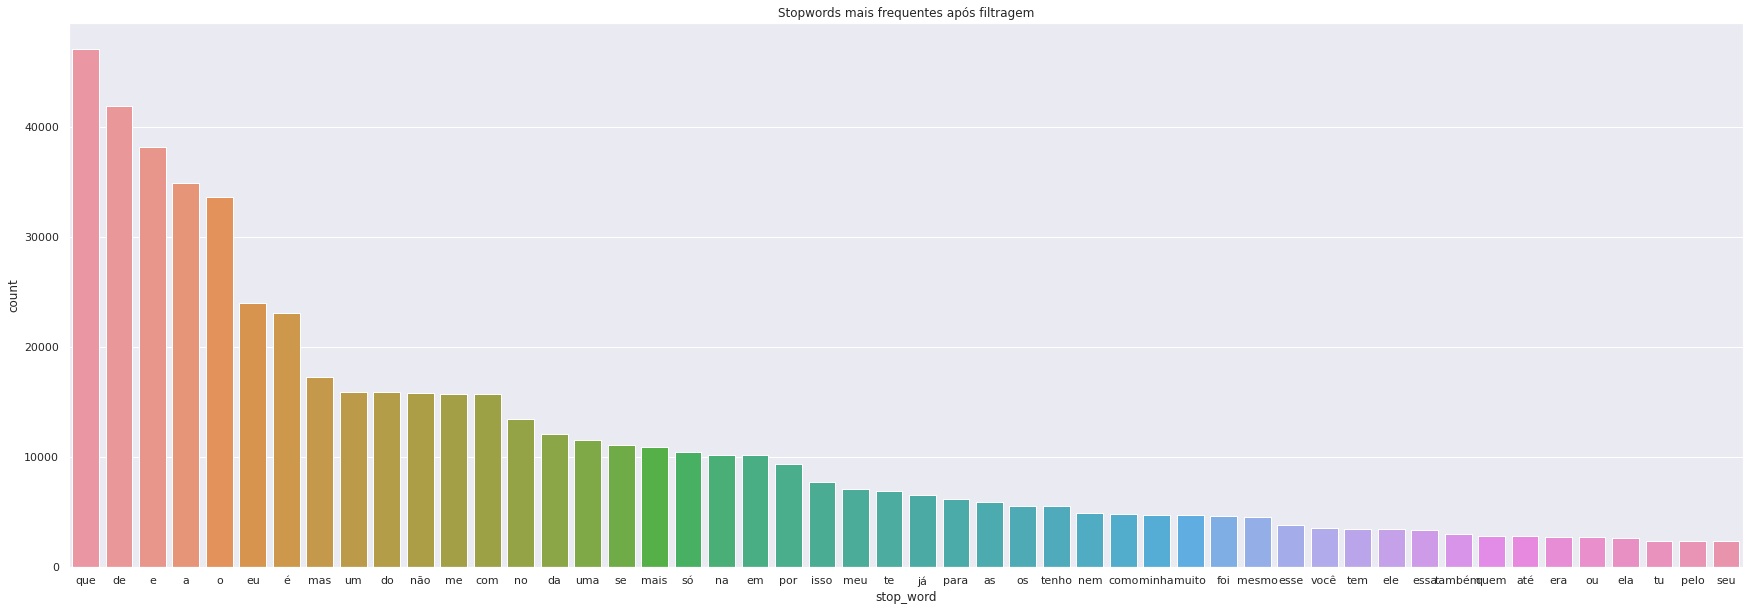

In [28]:
relevant_stop_words = [
    "eu",
    "não",
    "meu",
    "minha",
    "muito",
    "você",
    "tem",
    "ele",
    "ela",
    "quando",
    "sou",
    "você",
    "sem",
    "estou",
]  # stopwords consideradas relevantes para análise de sentimento, serão mantinidas em todo o processo de análise
stopwords = list(
    filter(lambda x: x not in relevant_stop_words, stopwords)
)  # remove do conjunto de stopwords palavras que não serão consideradas para filtragem

for word in all_text.split():
    if word in stopwords:
        dic[word] += 1

top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:50]  # top 50 stopwords


stopwords_df = pd.DataFrame(top, columns=["stop_word", "count"])


sns.set(rc={"figure.figsize": (30, 10)})
sns.barplot(x="stop_word", y="count", data=stopwords_df)
plt.title("Stopwords mais frequentes após filtragem")
plt.show()

## Análise das palavras mais frequentes que não são stop words.

#### Nota-se que há várias expressões e abreviações comuns  na internet e na língua portuguesa.

[('eu', 23966), ('que', 23558), ('de', 20989), ('e', 19107), ('a', 17470), ('o', 16836), ('não', 15828), ('é', 11548), ('mas', 8650), ('um', 7973), ('do', 7948), ('me', 7849), ('com', 7842), ('pra', 7598), ('meu', 7111), ('no', 6746), ('da', 6027), ('uma', 5763), ('se', 5553), ('mais', 5437), ('só', 5236), ('na', 5099), ('em', 5080), ('q', 5028), ('minha', 4720), ('por', 4687), ('muito', 4672), ('queria', 4572), ('to', 4195), ('vou', 3909), ('isso', 3874), ('você', 3565), ('tem', 3485), ('te', 3452), ('ele', 3403), ('vai', 3375), ('já', 3272), ('para', 3079), ('vc', 3024), ('d', 2963), ('as', 2952), ('n', 2928), ('bem', 2925), ('ter', 2797), ('dia', 2776), ('os', 2767), ('tenho', 2763), ('pq', 2750), ('triste', 2666), ('p', 2647), ('tá', 2634), ('ser', 2599), ('ela', 2590), ('nem', 2450), ('como', 2401), ('amo', 2347), ('tô', 2337), ('tudo', 2327), ('agora', 2326), ('ver', 2311), ('foi', 2306), ('nao', 2306), ('mesmo', 2283), ('tão', 2247), ('gente', 2199), ('quero', 2195), ('fazer', 2

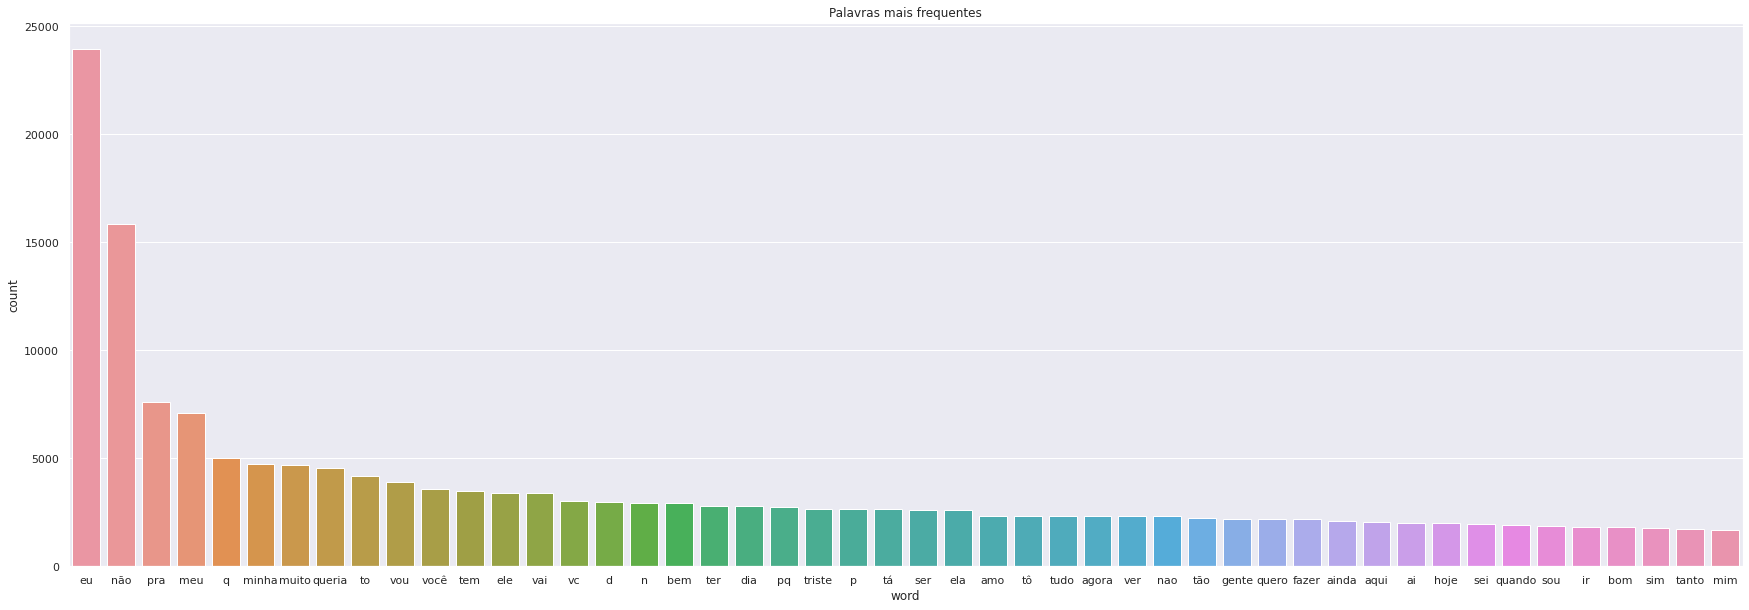

In [29]:
from collections import Counter


counter = Counter(all_text.split())
most = counter.most_common(80)
print(most)
print(len(most))

x, y = [], []
for word, count in most:
    if word not in stopwords:
        x.append(word)
        y.append(count)

most_common_words = list(zip(x, y))

most_common_words_df = pd.DataFrame(
    most_common_words, columns=["word", "count"]
)  # cria um dataframe com as palavras mais frequentes

sns.set(rc={"figure.figsize": (30, 10)})
sns.barplot(x="word", y="count", data=most_common_words_df)
plt.title("Palavras mais frequentes")
plt.show()

## Adiciona stopwords com palavras ou símbolos não relevantes para análise, descoberto com os gráficos anteriores.

In [36]:
invalid_terms = [
    "p",  # indentificava apenas como "p"
    "d",  # indentificava apenas como "d"
    "(",
    "pra",
    "q",
    "_",
    "((",
    "pq",
    "ai",
    "D",
    "P",
]  # palavras inrelevantes para análise de sentimento, ou termos abreviados já contidos em stopwords

stopwords.extend(invalid_terms)

counter = Counter(all_text.split())
most = counter.most_common(80)
print(most)
print(len(most))

x, y = [], []
for word, count in most:
    if word not in stopwords:
        x.append(word)
        y.append(count)


most_common_words_filtered = list(zip(x, y))

most_common_words_filtered_df = pd.DataFrame(
    most_common_words_filtered, columns=["word", "count"]
)

[('eu', 23966), ('que', 23558), ('de', 20989), ('e', 19107), ('a', 17470), ('o', 16836), ('não', 15828), ('é', 11548), ('mas', 8650), ('um', 7973), ('do', 7948), ('me', 7849), ('com', 7842), ('pra', 7598), ('meu', 7111), ('no', 6746), ('da', 6027), ('uma', 5763), ('se', 5553), ('mais', 5437), ('só', 5236), ('na', 5099), ('em', 5080), ('q', 5028), ('minha', 4720), ('por', 4687), ('muito', 4672), ('queria', 4572), ('to', 4195), ('vou', 3909), ('isso', 3874), ('você', 3565), ('tem', 3485), ('te', 3452), ('ele', 3403), ('vai', 3375), ('já', 3272), ('para', 3079), ('vc', 3024), ('d', 2963), ('as', 2952), ('n', 2928), ('bem', 2925), ('ter', 2797), ('dia', 2776), ('os', 2767), ('tenho', 2763), ('pq', 2750), ('triste', 2666), ('p', 2647), ('tá', 2634), ('ser', 2599), ('ela', 2590), ('nem', 2450), ('como', 2401), ('amo', 2347), ('tô', 2337), ('tudo', 2327), ('agora', 2326), ('ver', 2311), ('foi', 2306), ('nao', 2306), ('mesmo', 2283), ('tão', 2247), ('gente', 2199), ('quero', 2195), ('fazer', 2

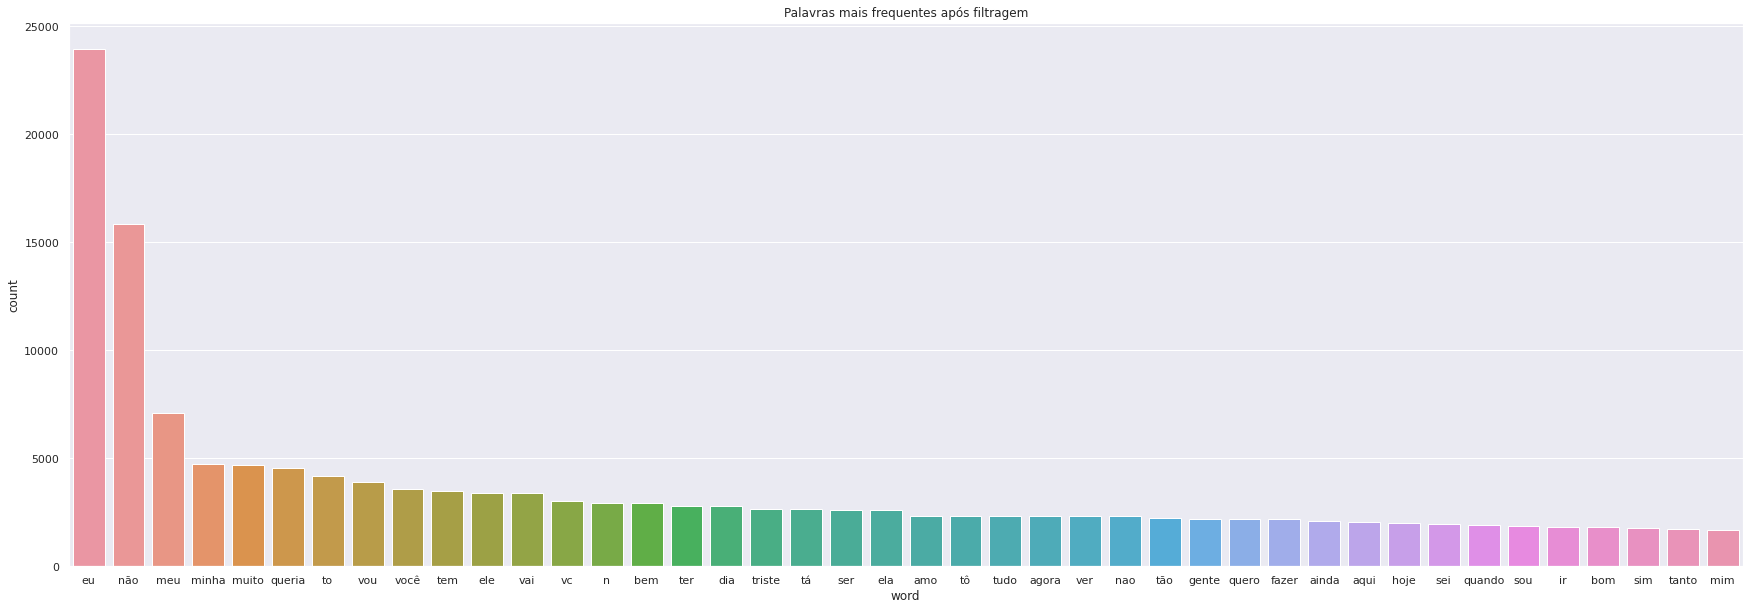

In [37]:
sns.set(rc={"figure.figsize": (30, 10)})
sns.barplot(x="word", y="count", data=most_common_words_filtered_df)
plt.title("Palavras mais frequentes após filtragem")
plt.show()

## Utilizando as análises anteriores é definido um conjunto final de stop words que é utilizada para filtra todos os corpus
<h4 style="color:red"> Essas stopwords importantes serão salvas em um arquivo .txt na pasta data/processed para o uso em etapas futuras</h4>

In [38]:
with open("../data/processed/stopwords.txt", "a") as file:
    for word in stopwords:
        file.write(word)
        file.write("\n")
    file.close()

#### Liberação de espaço na memória

In [33]:
del df, df_all, file

### Remoção das stopwords e criação dos Corpus

In [39]:
final_stop_words = stopwords

positive_filter = remover_stop_words(positive_text, final_stop_words)
negative_filter = remover_stop_words(negative_text, final_stop_words)
all_text_filter = remover_stop_words(all_text, final_stop_words)

## Plotagem visual das palavras mais comuns em cada um dos corpus.

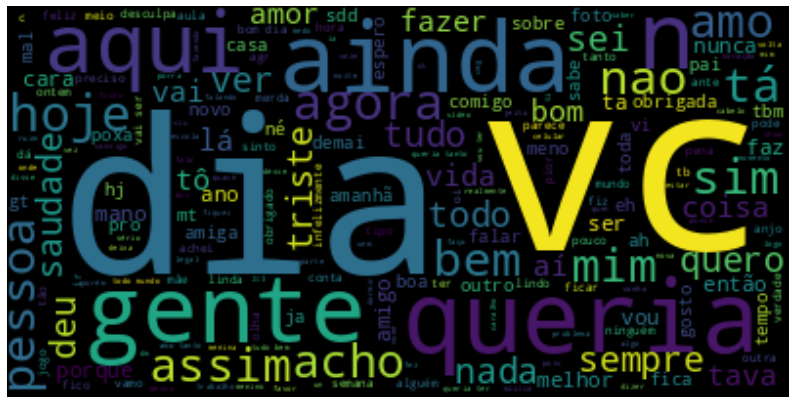

In [40]:
wordcloud = WordCloud().generate(all_text_filter)
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

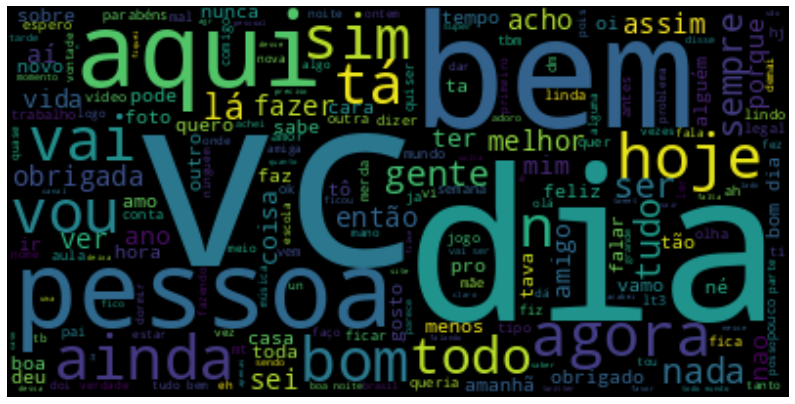

In [41]:
# Generate a word cloud image
wordcloud = WordCloud().generate(positive_filter)
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

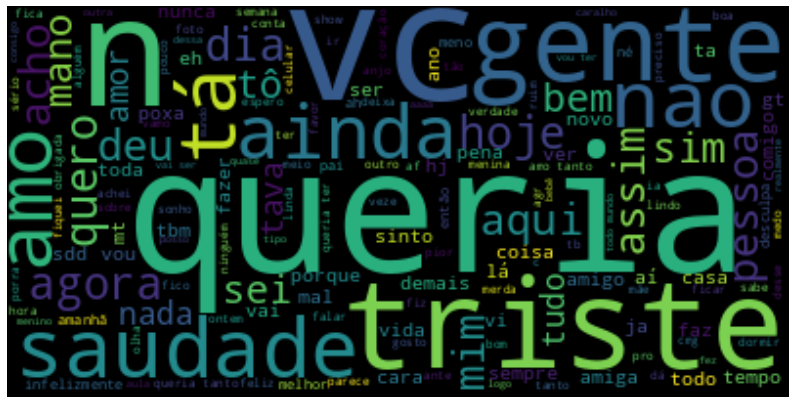

In [42]:
wordcloud = WordCloud().generate(negative_filter)
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Plotagem visual dos radicais mais comuns em cada um dos corpus.

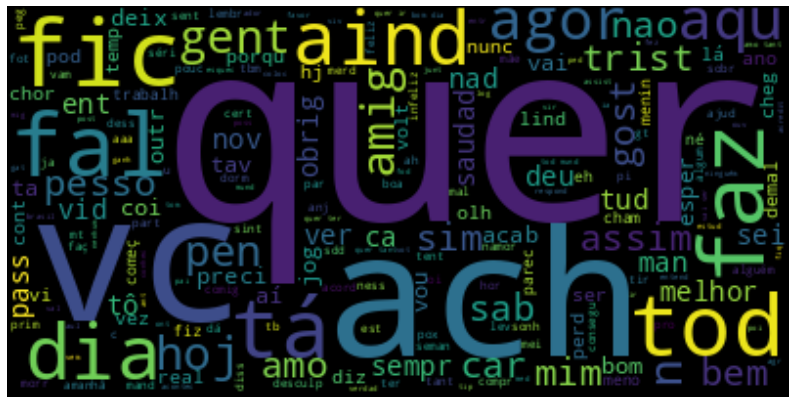

In [43]:
wordcloud = WordCloud().generate(stemming(all_text_filter))
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

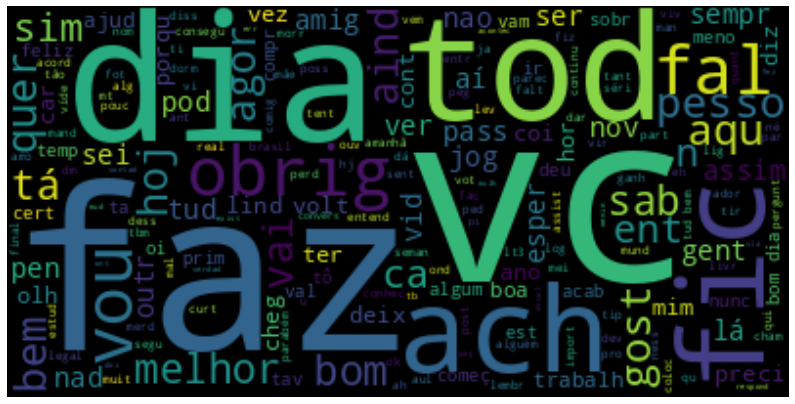

In [44]:
wordcloud = WordCloud().generate(stemming(positive_filter))
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

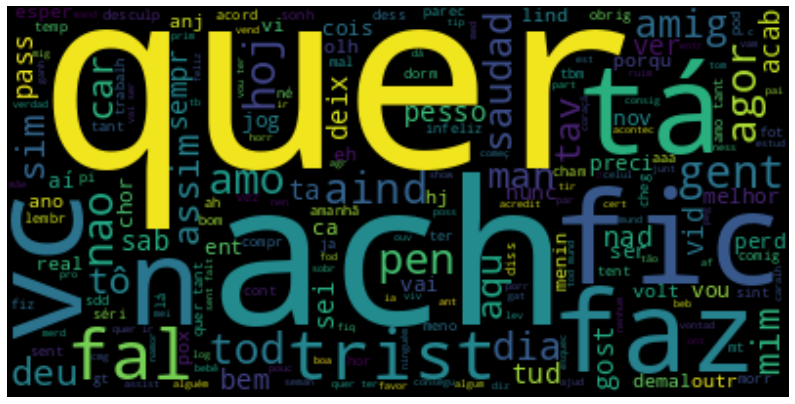

In [45]:
wordcloud = WordCloud().generate(stemming(negative_filter))
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Analise dos ngram mais comuns nos corpus.

## Há uma recorrencial de ngrams com termos como "gt", "it","amp" que não consegui identificar o que significam. Além disso há presença de muitas datas de notícias importante que aconteceram na época, e que as pessoas comentaram na época.

In [55]:
# top_2_gram = get_top_ngram(all_text_filter.split(), gram_size=2, top_gram=20 )


# top_2_gram_df = pd.DataFrame(top_2_gram, columns=["ngram", "count"])

# sns.set(rc={"figure.figsize": (30, 10)})
# sns.barplot(x="ngram", y="count", data=top_2_gram_df)
# plt.title("Ngram mais frequentes após filtragem")
# plt.show()

In [56]:
# top_3_gram = get_top_ngram(all_text_filter.split(), gram_size=3, top_gram=20)


# top_3_gram_df = pd.DataFrame(top_3_gram, columns=["ngram", "count"])


# sns.set(rc={"figure.figsize": (30, 10)})
# sns.barplot(x="ngram", y="count", data=top_3_gram_df)
# plt.title("Ngram mais frequentes após filtragem")
# plt.show()

In [57]:
# top_2_gram = get_top_ngram(positive_filter.split(), gram_size=2, top_gram=20 )

# top_2_gram_df = pd.DataFrame(top_2_gram, columns=["ngram", "count"])


# sns.set(rc={"figure.figsize": (30, 10)})
# sns.barplot(x="ngram", y="count", data=top_2_gram_df)
# plt.title("Ngram mais frequentes após filtragem")
# plt.show()

In [58]:
# top_2_gram = get_top_ngram(negative_filter.split(), gram_size=2, top_gram=20 )

# top_2_gram_df = pd.DataFrame(top_2_gram, columns=["ngram", "count"])


# sns.set(rc={"figure.figsize": (30, 10)})
# sns.barplot(x="ngram", y="count", data=top_2_gram_df)
# plt.title("Ngram mais frequentes após filtragem")
# plt.show()

In [36]:
# whos

In [59]:
df_positivo.head()

,id,tweet_text,sentiment,query_used,number_words,date,day_period,avg_word_length
15242,1031360746012258305,rapaz não acabou não e eu tô indo dormir de no...,Positivo,:),12,2018-08-19 23:02:18+00:00,night,3.250000
262963,1036590803819352064,vais ser tu ou o flávio,Positivo,:),8,2018-09-03 09:24:41+00:00,morning,3.000000
719555,1045354497684512770,entende que vc é feia e ninguém nunca vai se i...,Positivo,:),24,2018-09-27 13:48:28+00:00,afternoon,3.952381
25283,1031077431275335680,tenho te visto por ponte de lima pareces super...,Positivo,:),21,2018-08-19 04:16:30+00:00,overnight,4.000000
514705,1041689911303262209,ano que vem eu vou a um jogo no arruda,Positivo,:),12,2018-09-17 11:06:43+00:00,morning,2.900000


### Salvando a versão final dos dados limpos após a adição das coluna: numero de palavras, day_period e avg_word_length

In [37]:
# df_positivo.to_csv("../data/clean-dataset/tweets-positivos-final.csv", sep="\t", index=False)
# df_negativo.to_csv("../data/clean-dataset/tweets-negativos-final.csv", sep="\t", index=False)